## K-Means Clustering
### Overview
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:

- Read and understand the data
- Clean the data
- Prepare the data for modelling
- Modelling
- Final analysis

### 1. Read and visualise the data

In [2]:
# Importing necessary libraries
import numpy as np  # Numerical operations library
import pandas as pd  # Data manipulation library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization library

import datetime as dt  # Library for working with dates and times

import sklearn  # Machine learning library
from sklearn.preprocessing import StandardScaler  # Standardizing features
from sklearn.cluster import KMeans  # KMeans clustering algorithm
from sklearn.metrics import silhouette_score  # Metric for cluster evaluation

from scipy.cluster.hierarchy import linkage  # Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram  # Plotting dendrogram
from scipy.cluster.hierarchy import cut_tree  # Cutting hierarchical clustering tree

import warnings

# Ignore warnings for the duration of this cell
warnings.filterwarnings("ignore")


In [3]:
# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# Displaying the shape of the DataFrame (number of rows and columns)
retail_df.shape

(541909, 8)

In [5]:
# Displaying concise information about the DataFrame
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 2. Clean the Data

In [6]:
# Calculating the percentage of missing values in each column of the DataFrame
# Rounding the percentage to two decimal places
round(100*(retail_df.isnull().sum()/len(retail_df)),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

Explanation of the output:

The Description column has 0.27% missing values.
The CustomerID column has 24.93% missing values.
Other columns have no missing values (0.00% count).
This information is useful for understanding the extent of missing data in each column, which can help guide decisions on how to handle or impute missing values during data preprocessing.

In [7]:
# Dropping rows containing any missing values (NaN) from the DataFrame
retail_df = retail_df.dropna()

# Displaying the new shape of the DataFrame after dropping missing values
retail_df.shape

(406829, 8)

Explanation of the output:

After dropping rows with missing values, the DataFrame retail_df now has 406,829 rows and 8 columns.
It's important to note that dropping rows with missing values is one approach to handling missing data.  

### 3. Prepare data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [8]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [9]:
# monetry
# Grouping the DataFrame by 'CustomerID' and calculating the total monetary amount spent by each customer
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()

# Resetting the index to convert the result into a DataFrame
grouped_df = grouped_df.reset_index()

# Displaying the first 8 rows of the grouped DataFrame
grouped_df.head(8)

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
5,12352.0,1545.41
6,12353.0,89.00
7,12354.0,1079.40


In [10]:
# frequency
# Grouping the DataFrame by 'CustomerID' and calculating the frequency (number of invoices) for each customer
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()

# Resetting the index to convert the result into a DataFrame
frequency = frequency.reset_index()

# Renaming columns for clarity
frequency.columns = ['CustomerID', 'frequency']

# Displaying the first few rows of the frequency DataFrame
frequency.head(8)

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
5,12352.0,95
6,12353.0,4
7,12354.0,58


In [11]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [17]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x1e9cdd0d3c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e9cdd0d900>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e9cdd0d120>],
 'medians': [<matplotlib.lines.Line2D at 0x1e9cdd0de40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e9cdd0e0e0>],
 'means': []}

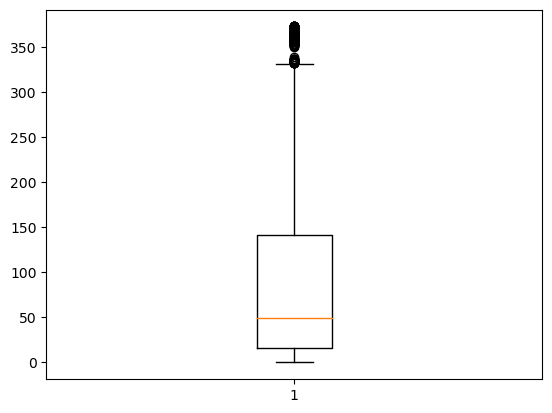

In [18]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

In [19]:
# two types of outliers:
# - statistical
# - domain specific

# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [20]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


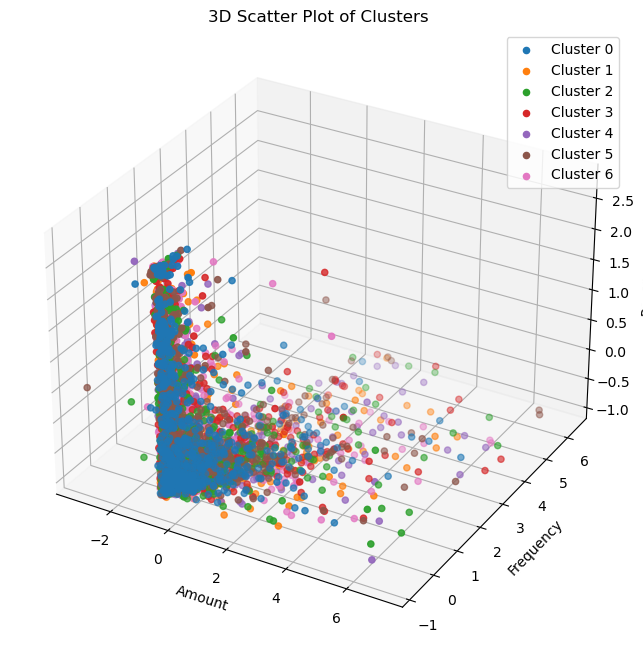

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()


data = rfm_df_scaled  # Use the scaled DataFrame

np.random.seed(42)  # for reproducibility
cluster_labels = np.random.randint(0, 7 , len(data))  

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in set(cluster_labels):
    cluster_data = data[cluster_labels == cluster_label]
    ax.scatter(cluster_data['amount'], cluster_data['frequency'], cluster_data['recency'], label=f'Cluster {cluster_label}')

# Set labels and title
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Clusters')

# Display legend
ax.legend()

# Show the plot
plt.show()


In [22]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

Finding the Optimal Number of Clusters

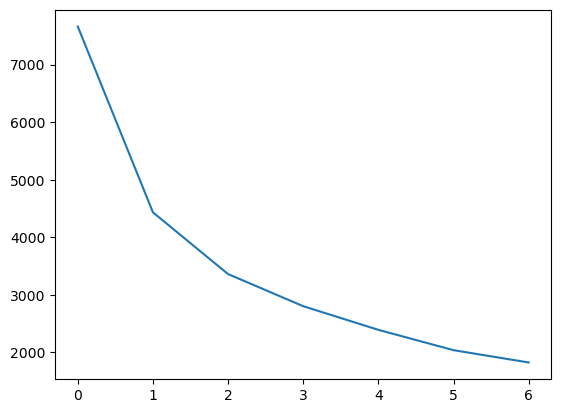

In [23]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [24]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.47782241003860476
For n_clusters=5, the silhouette score is 0.4646444032280179
For n_clusters=6, the silhouette score is 0.41758431193450735
For n_clusters=7, the silhouette score is 0.41768907282021733
For n_clusters=8, the silhouette score is 0.4093799889419855


In [25]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


<Axes: xlabel='cluster_id', ylabel='amount'>

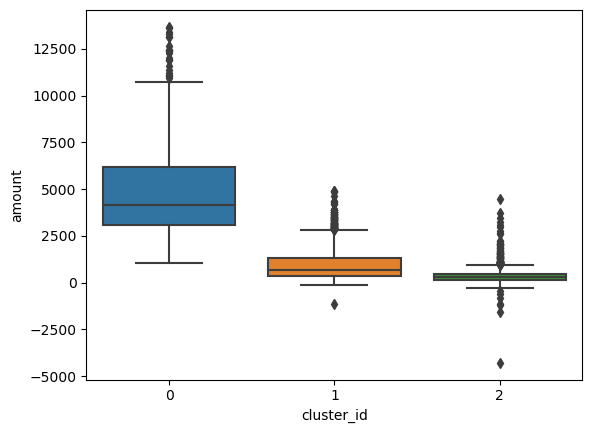

In [26]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

## Hierarchical Clustering

In [27]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [28]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


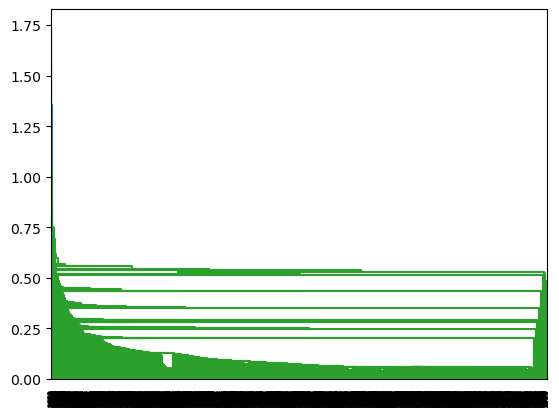

In [29]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [30]:
pip install mplcursors


Note: you may need to restart the kernel to use updated packages.


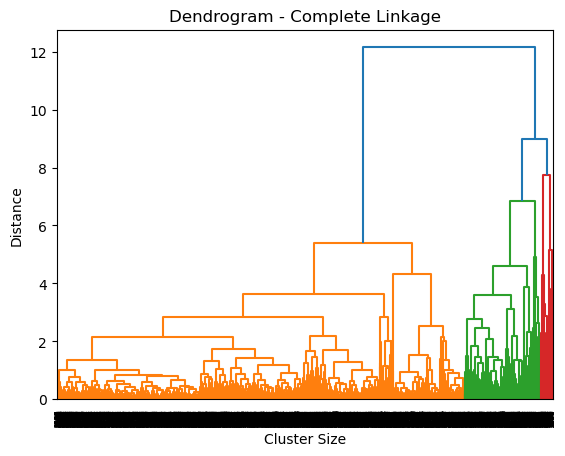

In [31]:
# complete linkage
import mplcursors  # For cursor hover support

# Assuming rfm_df_scaled is your scaled DataFrame
# You might need to import it or define it before using this code

# Complete linkage hierarchical clustering
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')

# Plotting the dendrogram with interactive cursor hover support
dendrogram(mergings)

# Adding labels to the dendrogram for better interpretation
plt.title('Dendrogram - Complete Linkage')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

# Adding cursor hover support for more interactivity
mplcursors.cursor(hover=True)

# Display the interactive dendrogram
plt.show()


In [32]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


<Axes: xlabel='cluster_labels', ylabel='recency'>

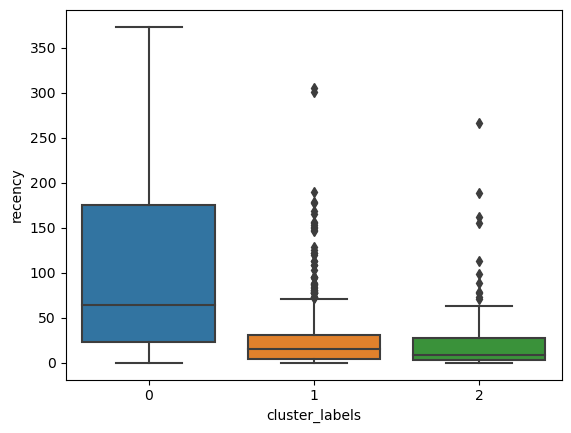

In [33]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

<Axes: xlabel='cluster_labels', ylabel='frequency'>

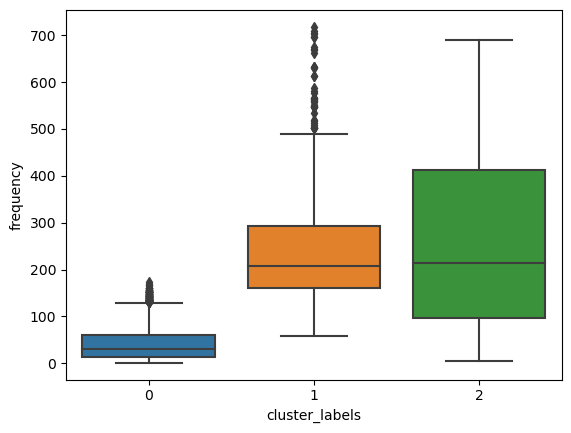

In [34]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

<Axes: xlabel='cluster_labels', ylabel='amount'>

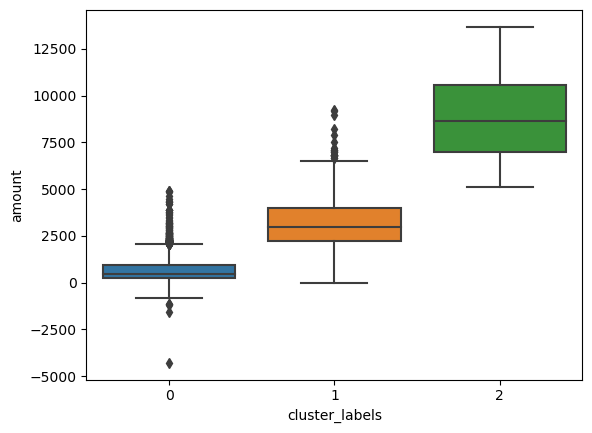

In [35]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)